## ToDo List
- [x] Checar se formato de datas conferem.
- [x] Remover UGs sem liberação OC
- [x] Considerar coluna montagem. Onde estiver vazio, pegar valor de Torres para EOL, no skate.
- [ ] Separar um cojunto aleatório para teste
- [x] Calcular tempos de construção por marco: (IO_realizado - realizado), (CC_realizado - realizado) ...etc  (ordem:IO,CC,ME,OT)
- [x] Calcular atraso da operação comercial (realizado - outorgado)
- [x] Calcular média e dp do tempo de construção.
- [x] Calcular data dos marcos medios (outorgado - tempo_medio_de_construcao) por fonte.
- [x] Calcular atrasos com base nos marcos medios
- [ ] Calcular media e dp dos atrasos. 
- [ ] Normalizar os atrasos calculados (atraso - atraso_medio)/dp
- [x] Construir matriz de correlação de Pearson
- [ ] Calcular os coeficientes para regressão linear
- [x] Para UHE pegar todas UGs, para as demais pegar a primeira UG apenas 
- [ ] Comparar pegando primeira UG e media por grupo

In [1]:
import pandas as pd
import numpy as np
import re
import pyodbc
from pprint import pprint
import matplotlib.pyplot as plt
#from sklearn.linear_model import LinearRegression
from scipy import stats

from itertools import combinations

#### Transforma coluna IdeUsinaOutorga das UHEs para que cada UG possua esse campo diferente. Por exemplo as UGs da usina 12 serão 12_0, 12_1...

In [2]:
bd_combined = pd.read_parquet("bd_combined.gzip")

In [3]:
bd_combined.index.name = "idx"
bd_combined.IdeUsinaOutorga = bd_combined.IdeUsinaOutorga.astype(str)
mask_UHE_duplicate = (bd_combined.SigTipoGeracao == "UHE") & (bd_combined.IdeUsinaOutorga.duplicated(keep=False))
bd_combined.loc[mask_UHE_duplicate,"IdeUsinaOutorga"] = bd_combined.loc[mask_UHE_duplicate,"IdeUsinaOutorga"] +"_"+ bd_combined.loc[mask_UHE_duplicate].groupby("IdeUsinaOutorga").cumcount().astype(str)
bd_combined.sample(15)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
5098,47229,2024-04-08,2024-07-31,NaT,NaT,MG,48118.00,2023-08-17,NaT,NaT,...,None,NaT,NaT,2023-10-17,NaT,UFV,14,48118.00,skate,2022-03-15
2530,30447,NaT,2019-10-18,2020-04-03,2020-05-07,SP,33000.00,NaT,2018-04-07,NaT,...,None,NaT,NaT,NaT,2018-04-07,UTE,1,6000.00,skate,2020-01-17
4292,38320,2023-12-02,2024-01-01,2021-07-24,2021-08-19,RN,63000.00,2023-01-31,2020-08-13,2023-04-01,...,None,NaT,NaT,2023-01-31,2020-06-23,EOL,1,4200.00,skate,2019-01-09
4237,38198,2023-10-01,2023-12-01,NaT,NaT,CE,30000.00,2022-07-01,NaT,NaT,...,None,NaT,NaT,2022-09-01,NaT,UFV,10,30000.00,skate,2021-06-29
3340,34645,2021-07-04,2021-08-31,2021-04-08,2021-05-21,BA,33600.00,2019-09-15,2019-08-03,2020-08-05,...,None,NaT,NaT,2019-08-31,2019-10-04,EOL,2,8400.00,skate,2019-12-10
391,29013,2006-03-01,2006-05-01,2007-04-19,2007-06-05,MS,13.00,2004-07-15,NaT,2005-02-01,...,None,NaT,NaT,NaT,NaT,PCH,2,13.00,bdworgs,None
1950,33136,2017-11-15,2018-01-01,2017-10-19,2017-11-17,PI,29.40,2017-03-15,2016-10-15,2017-05-01,...,2017-08-24,NaT,NaT,2017-04-01,2016-10-15,EOL,5,10.50,bdworgs,None
4460,40612,2023-12-01,2024-01-01,2021-07-21,2021-08-03,BA,20400.00,2022-08-01,2020-08-08,2022-12-30,...,None,NaT,NaT,2023-06-15,2019-12-20,EOL,1,5100.00,skate,2019-01-28
4209,38134,2024-03-27,2024-05-15,NaT,NaT,PE,49600.00,2022-12-12,NaT,2023-03-06,...,None,NaT,NaT,2023-02-06,NaT,EOL,8,49600.00,skate,2022-04-12


#### Remove linhas cujas colunas DatUGInicioOpComerOutorgado e DatLiberOpComerRealizado não sejam nulas

In [4]:
mask_OC_notna = bd_combined.DatUGInicioOpComerOutorgado.notna() & bd_combined.DatLiberOpComerRealizado.notna()
bd_combined = bd_combined[mask_OC_notna].copy(deep=True)

In [5]:
dict_nome_marco = {
    "IO_OC" : "DatInicioObraRealizado",
    "CC_OC" : "DatConcretagemRealizado",
    "ME_OC" : "DatMontagemRealizado",
    "OT_OC" : "DatLiberacaoSFGTeste"
}

dict_marco_nome = {v: k for k, v in dict_nome_marco.items()}


tempo_construcao_por_UG = bd_combined[["IdeUsinaOutorga","SigTipoGeracao","origem"]].copy(deep=True)
for nome,marco in dict_nome_marco.items():
    tempo_construcao_por_UG[nome] = bd_combined["DatLiberOpComerRealizado"]-  bd_combined[marco]

tempo_construcao_por_UG["Atraso"]  =  bd_combined["DatLiberOpComerRealizado"]-  bd_combined["DatUGInicioOpComerOutorgado"] 
tempo_construcao_por_UG.head(25)

,IdeUsinaOutorga,SigTipoGeracao,origem,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,
0,12_0,UHE,bdworgs,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,bdworgs,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,bdworgs,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,bdworgs,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,bdworgs,1553 days,NaT,NaT,11 days,0 days
5,42_2,UHE,bdworgs,1615 days,NaT,NaT,24 days,0 days
6,127,UTE,bdworgs,561 days,NaT,NaT,NaT,15 days
7,161,PCH,bdworgs,1163 days,677 days,NaT,38 days,2290 days
9,291,PCH,bdworgs,697 days,419 days,NaT,45 days,1676 days


In [6]:
is_first = True 
combinacoes = list(combinations([x for x in tempo_construcao_por_UG.columns if x not in ["IdeUsinaOutorga","SigTipoGeracao","Atraso","origem"]],2))
motivo_eliminacao = tempo_construcao_por_UG[["SigTipoGeracao","origem"]].copy(deep=True)
motivo_eliminacao["motivo_eliminacao"] = ""

for p_marco, s_marco in combinacoes:
    mask_ordem_correta_parcial =  ((tempo_construcao_por_UG[p_marco] >= tempo_construcao_por_UG[s_marco]) | 
                 tempo_construcao_por_UG[p_marco].isna() | 
                 tempo_construcao_por_UG[s_marco].isna())
    
    motivo_eliminacao.loc[~mask_ordem_correta_parcial,"motivo_eliminacao"] += f"{s_marco[:-3]}>{p_marco[:-3]},"
    mask_ordem_correta = mask_ordem_correta_parcial if is_first else (mask_ordem_correta & mask_ordem_correta_parcial)
    is_first = False 
motivo_eliminacao =motivo_eliminacao[~mask_ordem_correta]
tempo_construcao_por_UG_filtered = tempo_construcao_por_UG[mask_ordem_correta].copy(deep=True)
tempo_construcao_por_UG_filtered

,IdeUsinaOutorga,SigTipoGeracao,origem,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,
0,12_0,UHE,bdworgs,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,bdworgs,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,bdworgs,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,bdworgs,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,bdworgs,1553 days,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...,...
5752,50872,UTE,skate,98 days,NaT,98 days,41 days,-920 days
5776,51444,UTE,skate,99 days,NaT,99 days,22 days,-385 days
5782,51450,UTE,skate,104 days,NaT,104 days,26 days,-380 days


In [8]:
idx_primeira_ug =  bd_combined[mask_ordem_correta].groupby(["IdeUsinaOutorga"],sort=False).DatLiberOpComerRealizado.idxmin()
bd_combined_usinas =   bd_combined.loc[idx_primeira_ug,:]
bd_combined_usinas.sample(10)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
2774,32453,2021-11-04,2022-02-04,2021-10-16,2021-11-30,CE,21000.0,2021-04-08,2021-05-14,2021-05-06,...,None,NaT,NaT,2020-06-01,2021-03-15,EOL,2,8400.00,skate,2019-12-17
564,29555,2008-12-22,2009-01-01,2010-02-27,2010-04-20,BA,150.0,2008-01-07,2008-01-15,NaT,...,None,NaT,NaT,NaT,NaT,UTE,2,80.00,bdworgs,None
639,29707_17,2013-12-01,2014-04-01,2013-08-16,2014-04-08,RO,3568.0,2008-12-01,2008-09-15,2010-04-01,...,None,2011-11-15,2012-01-23,NaT,2010-10-01,UHE,1,73.29,bdworgs,None
307,28804,2006-11-01,2006-12-31,2009-07-03,2009-08-14,RJ,20.0,2005-05-01,2007-10-15,2005-08-01,...,None,NaT,2009-02-15,NaT,NaT,PCH,2,20.00,bdworgs,None
1489,31363,2015-08-15,2015-09-01,2015-09-22,2015-12-25,PE,27.2,2014-11-15,2014-10-15,2015-01-01,...,2015-04-15,NaT,NaT,2014-12-01,2014-08-05,EOL,16,27.20,bdworgs,None
445,29116,2013-10-01,2014-03-01,2014-07-22,2014-09-02,MG,40.0,2004-12-01,2011-09-12,NaT,...,None,NaT,NaT,NaT,NaT,UTE,2,40.00,bdworgs,None
1311,30898,2015-12-01,2015-12-31,2014-10-22,2015-03-24,RN,30.0,2015-05-01,2014-01-15,2015-07-01,...,2014-08-15,NaT,NaT,2015-03-01,2013-08-19,EOL,1,3.00,bdworgs,None
2308,37976,2022-12-01,2023-01-01,2018-11-20,2018-12-28,MA,27.0,2022-03-01,2018-05-15,2022-06-01,...,2018-10-15,NaT,NaT,2022-08-01,2018-06-15,EOL,1,2.70,bdworgs,None
3115,33846,2021-11-11,2021-12-11,2020-04-02,2020-10-14,PI,45680.0,NaT,2019-03-08,NaT,...,None,NaT,NaT,2020-03-31,2018-12-13,UFV,16,45680.00,skate,2018-12-11


In [13]:
# Atrasos por usinas são calculados com base UG com menor atraso.
tempo_construcao_por_usina = tempo_construcao_por_UG_filtered.loc[idx_primeira_ug,:]
tempo_construcao_por_usina

,IdeUsinaOutorga,SigTipoGeracao,origem,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,
0,12_0,UHE,bdworgs,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,bdworgs,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,bdworgs,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,bdworgs,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,bdworgs,1553 days,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...,...
5752,50872,UTE,skate,98 days,NaT,98 days,41 days,-920 days
5776,51444,UTE,skate,99 days,NaT,99 days,22 days,-385 days
5782,51450,UTE,skate,104 days,NaT,104 days,26 days,-380 days


In [54]:
def divide(a,b):
    mask = a.notna()
    if len(a[mask])>0:
        a[mask] = a[mask]/b
    else:
        pass
    return a

tipos_geracao = bd_combined.SigTipoGeracao.unique()
tempo_construcao_por_usina_norm = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao"]]
dict_tempo_construcao_mean_dp = {}
for SigTipoGeracao in tipos_geracao:
    dict_tempo_construcao_mean_dp[SigTipoGeracao] = {}
    for tempo in ["IO_OC","CC_OC","ME_OC","OT_OC","Atraso"]:
        dict_tempo_construcao_mean_dp[SigTipoGeracao][tempo] = {}
        mask = tempo_construcao_por_usina.SigTipoGeracao==SigTipoGeracao
        m = tempo_construcao_por_usina.loc[mask,tempo].mean()
        s= tempo_construcao_por_usina.loc[mask,tempo].std()
        dict_tempo_construcao_mean_dp[SigTipoGeracao][tempo]["media"] = m.days/30
        dict_tempo_construcao_mean_dp[SigTipoGeracao][tempo]["dp"] = s.days/30
        tempo_construcao_por_usina_norm.loc[mask,tempo] = divide((tempo_construcao_por_usina.loc[mask,tempo] - m),s)   
tempo_construcao_por_usina_norm


,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
0,12_0,UHE,-0.510674,-1.267459,NaN,-0.671693,0.830213
1,12_1,UHE,-0.385251,-1.140075,NaN,-0.609173,-0.021921
2,19,UTE,-0.137639,NaT,NaN,-0.63144,2.862015
3,42_0,UHE,-0.528592,NaT,NaN,-0.640433,0.727525
4,42_1,UHE,-0.476468,NaT,NaN,-0.624803,-0.36782
...,...,...,...,...,...,...,...
5752,50872,UTE,-0.769889,NaN,-0.515903,-0.407591,-1.738998
5776,51444,UTE,-0.76858,NaN,-0.514677,-0.529109,-0.974306
5782,51450,UTE,-0.762035,NaN,-0.508543,-0.503526,-0.96716


In [16]:
# Cria tabela para calculos por geracao
tempo_construcao_por_geracao = pd.DataFrame()
tempo_construcao_por_geracao["SigTipoGeracao"] = bd_combined.SigTipoGeracao.unique() 


# Realiza calculos por geracao
for coluna in tempo_construcao_por_usina.columns:
    if coluna not in ["IdeUsinaOutorga","SigTipoGeracao","origem"]:
        tempo_construcao_por_geracao[f"{coluna}_media"] = tempo_construcao_por_geracao.SigTipoGeracao.apply(lambda x : tempo_construcao_por_usina[tempo_construcao_por_usina.SigTipoGeracao==x][coluna].mean())
        #tempo_construcao_por_geracao[f"{coluna}_std"] = tempo_construcao_por_geracao.SigTipoGeracao.apply(lambda x : tempo_construcao_por_usina[tempo_construcao_por_usina.SigTipoGeracao==x][coluna].std())

tempo_construcao_por_geracao.set_index("SigTipoGeracao",inplace=True)
display(tempo_construcao_por_geracao)

,IO_OC_media,CC_OC_media,ME_OC_media,OT_OC_media,Atraso_media
SigTipoGeracao,,,,,
UHE,1845 days 12:18:46.956521728,1621 days 03:27:45.671641792,1516 days 07:42:13.333333328,50 days 23:23:04.615384615,204 days 04:02:01.008403362
UTE,686 days 03:32:05.581395352,NaT,518 days 12:51:14.157303368,104 days 17:30:13.533834586,296 days 15:39:25.714285716
PCH,876 days 02:01:03.716814160,644 days 20:41:08.571428568,402 days 15:49:56.858638744,50 days 12:36:08.339768340,993 days 17:03:00.694980688
CGH,895 days 13:55:12,666 days 22:28:05.106382976,480 days 01:12:00,103 days 00:48:48.813559322,415 days 05:36:00
EOL,561 days 17:28:45.746799432,493 days 03:34:14.935622320,357 days 22:04:08.275862068,58 days 14:10:04.267425320,66 days 12:15:21.763869132
UFV,376 days 21:46:29.403973508,NaT,244 days 08:09:36,70 days 22:24:38.145695364,-5 days +20:20:39.735099338


In [17]:
marco_medio_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga"]]
def id_marco(ID,nome,marco):
    geracao = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"SigTipoGeracao"].values[0]
    tempo_medio = tempo_construcao_por_geracao.loc[geracao,f"{nome}_media"]
    data_OC = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"DatUGInicioOpComerOutorgado"].values[0]
    data_marco_medio = data_OC - tempo_medio
    return data_marco_medio


for nome,marco in dict_nome_marco.items():
    marco_medio_usina[f"{marco}_estimado"] = marco_medio_usina.IdeUsinaOutorga.apply(lambda ID :  id_marco(ID,nome,marco))

In [18]:
marco_medio_usina

,IdeUsinaOutorga,DatInicioObraRealizado_estimado,DatConcretagemRealizado_estimado,DatMontagemRealizado_estimado,DatLiberacaoSFGTeste_estimado
idx,,,,,
0,12_0,2002-02-09 11:41:13.043478272,2002-09-21 20:32:14.328358208,2003-01-04 16:17:46.666666672,2007-01-09 00:36:55.384615385
1,12_1,2003-08-13 11:41:13.043478272,2004-03-24 20:32:14.328358208,2004-07-07 16:17:46.666666672,2008-07-12 00:36:55.384615385
2,19,2000-02-14 20:27:54.418604648,NaT,2000-07-31 11:08:45.842696632,2001-09-18 06:29:46.466165414
3,42_0,1998-11-10 11:41:13.043478272,1999-06-22 20:32:14.328358208,1999-10-05 16:17:46.666666672,2003-10-10 00:36:55.384615385
4,42_1,2000-08-11 11:41:13.043478272,2001-03-23 20:32:14.328358208,2001-07-06 16:17:46.666666672,2005-07-11 00:36:55.384615385
...,...,...,...,...,...
5752,50872,2022-07-10 20:27:54.418604648,NaT,2022-12-25 11:08:45.842696632,2024-02-12 06:29:46.466165414
5776,51444,2021-05-14 20:27:54.418604648,NaT,2021-10-29 11:08:45.842696632,2022-12-17 06:29:46.466165414
5782,51450,2021-05-14 20:27:54.418604648,NaT,2021-10-29 11:08:45.842696632,2022-12-17 06:29:46.466165414


In [19]:
atraso_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao","Atraso"]]
nomes_colunas_atrasos = []
for nome,marco in dict_nome_marco.items():
    nome_coluna = f"{marco}_atraso"
    nomes_colunas_atrasos.append(nome_coluna)
    atraso_usina[nome_coluna] = bd_combined_usinas[marco] - marco_medio_usina[f"{marco}_estimado"]

In [20]:
atraso_usina.sample(10)

,IdeUsinaOutorga,SigTipoGeracao,Atraso,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
idx,,,,,,,
741,29736_33,UHE,-465 days,-407 days +12:18:46.956521728,-600 days +03:27:45.671641792,-615 days +07:42:13.333333328,-450 days +23:23:04.615384615
1085,30537,EOL,1145 days,460 days 17:28:45.746799432,483 days 03:34:14.935622320,517 days 22:04:08.275862068,1165 days 14:10:04.267425320
1104,30557_2,UHE,401 days,437 days 12:18:46.956521728,577 days 03:27:45.671641792,727 days 07:42:13.333333328,145 days 23:23:04.615384615
2620,31271,EOL,597 days,332 days 17:28:45.746799432,281 days 03:34:14.935622320,555 days 22:04:08.275862068,627 days 14:10:04.267425320
610,29665,UTE,-327 days,-307 days +03:32:05.581395352,NaT,NaT,-273 days +17:30:13.533834586
340,28848,PCH,924 days,NaT,NaT,NaT,934 days 12:36:08.339768340
647,29707_25,UHE,-249 days,-423 days +12:18:46.956521728,-342 days +03:27:45.671641792,-323 days +07:42:13.333333328,-212 days +23:23:04.615384615
3677,35826,UTE,675 days,789 days 03:32:05.581395352,NaT,850 days 12:51:14.157303368,485 days 17:30:13.533834586
65,2754,PCH,2913 days,2915 days 02:01:03.716814160,2776 days 20:41:08.571428568,NaT,2942 days 12:36:08.339768340


In [88]:
dict_atraso_mean_dp = {}
for SigTipoGeracao in tipos_geracao:
    dict_atraso_mean_dp[SigTipoGeracao] = {}
    for marco in dict_marco_nome.keys():
        marco += "_atraso"
        dict_atraso_mean_dp[SigTipoGeracao][marco] = {}
        mask = atraso_usina.SigTipoGeracao==SigTipoGeracao
        m = atraso_usina.loc[mask,marco].mean()
        s= atraso_usina.loc[mask,marco].std()
        dict_atraso_mean_dp[SigTipoGeracao][marco]["media"] = m/30
        dict_atraso_mean_dp[SigTipoGeracao][marco]["dp"] = s/30


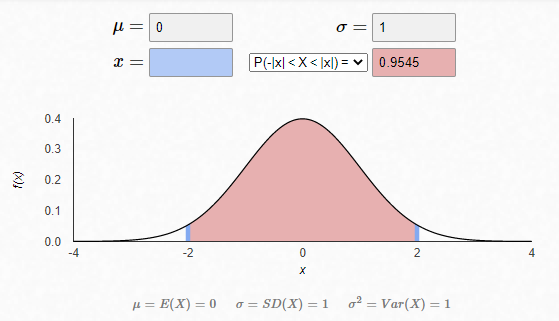

Não foi possível calcular: DatConcretagemRealizado_atraso para UTE
zero-size array to reduction operation minimum which has no identity
Não foi possível calcular: DatConcretagemRealizado_atraso para UFV
zero-size array to reduction operation minimum which has no identity


,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
UHE,71.4%,74.1%,43.9%,99.9%
UTE,80.6%,-,79.2%,99.3%
PCH,96.1%,96.9%,98.6%,99.8%
CGH,71.3%,87.1%,92.2%,99.7%
EOL,88.8%,88.4%,91.7%,99.9%
UFV,94.8%,-,94.9%,99.0%


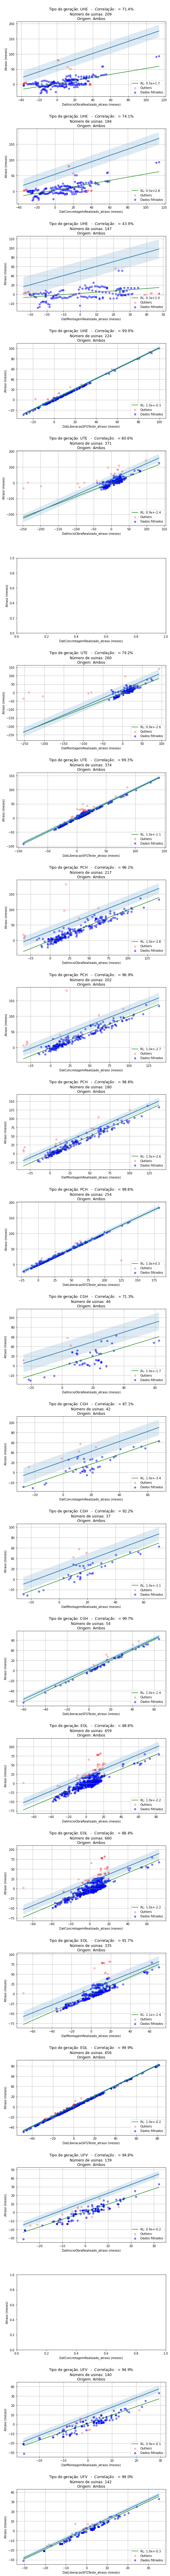

In [119]:
plot_created = False
analises_origem =["Ambos"]     #["skate","bdworgs","Ambos"]

matrix_pearson = {}
matrix_pearson_out = {}

def calc_regression():
    res = stats.linregress(x.flatten(), y.flatten())
    a, b, r, p_value, std_err = res
    
    return [a, b, r, p_value, std_err]
    
def start_axes():
    ax = axes[count]
    ax.set_xlabel(f"{nome_coluna} (meses)")
    ax.set_ylabel(f"Atraso (meses)")
    return ax


for k,origem in enumerate(analises_origem):
    
    if not plot_created:    
        num_subplots = (len(tipos_geracao))*(len(nomes_colunas_atrasos))
        fig, axes = plt.subplots(num_subplots,len(analises_origem),figsize=(len(analises_origem)*8,num_subplots*5))
        plot_created =True
    count = -1
    for i,SigTipoGeracao in enumerate(tipos_geracao):
        matrix_pearson[SigTipoGeracao] = []
        for nome_coluna in nomes_colunas_atrasos:
            count+=1
            try:
                ax = start_axes()
                
                # Calcula outliers
                idx_notna = (atraso_usina[nome_coluna].notna()) & (atraso_usina.SigTipoGeracao == SigTipoGeracao) 
                ordered_notna = atraso_usina[idx_notna].sort_values(by = nome_coluna)
                x = ordered_notna[nome_coluna].dt.days.to_numpy().reshape(-1, 1)/30
                y = ordered_notna["Atraso"].dt.days.to_numpy().reshape(-1, 1)/30
                x_plot = np.linspace(x.min(),x.max(),100)
                z_th = 1.65
                
                #m = dict_atraso_mean_dp[SigTipoGeracao][nome_coluna]["media"]
                #dp = dict_atraso_mean_dp[SigTipoGeracao][nome_coluna]["dp"]
                
                m = dict_tempo_construcao_mean_dp[SigTipoGeracao][dict_marco_nome[nome_coluna[:-7]]]["media"]
                dp = dict_tempo_construcao_mean_dp[SigTipoGeracao][dict_marco_nome[nome_coluna[:-7]]]["dp"]
                
                th_mes = (z_th*dp)+m
                
                
                #outliers = ((tempo_construcao_por_usina[dict_marco_nome[nome_coluna[:-7]]]) > th_mes)| ((tempo_construcao_por_usina[dict_marco_nome[nome_coluna[:-7]]]) < -th_mes)
                outliers = ((tempo_construcao_por_usina_norm[dict_marco_nome[nome_coluna[:-7]]]) > z_th)| ((tempo_construcao_por_usina_norm[dict_marco_nome[nome_coluna[:-7]]]) < -z_th)
                
                # Plota outliers
                ordered_notna_out = atraso_usina[ idx_notna & outliers ].sort_values(by = nome_coluna)
    
                x = ordered_notna_out[nome_coluna].dt.days.to_numpy().reshape(-1, 1)/30
                y = ordered_notna_out["Atraso"].dt.days.to_numpy().reshape(-1, 1)/30
                
                ax.scatter(x,y,color="red",alpha=0.25,label="Outliers")
                
                
                ordered_notna_not_out = atraso_usina[ idx_notna & ~outliers ].sort_values(by = nome_coluna)
                x = ordered_notna_not_out[nome_coluna].dt.days.to_numpy().reshape(-1, 1)/30
                y = ordered_notna_not_out["Atraso"].dt.days.to_numpy().reshape(-1, 1)/30
                ax.scatter(x,y,color="blue",alpha=0.5,label="Dados filtrados")
                a, b, r, p_value, std_err = calc_regression()
                r_str = f"{100*r:.1f}%"
                matrix_pearson[SigTipoGeracao].append(r_str)
                ax.plot(x_plot,a*x_plot+b+1,color="green",label= f"RL: {a:.1f}x+{b:.1f}")
                ax.set_title(f"\nTipo de geração: {SigTipoGeracao}   -  $Correlação:$ = {r_str}\nNúmero de usinas: {x.shape[0]} \nOrigem: {origem}")
                ax.legend(loc="lower right")
                ax.grid()
                

                ax.plot(x_plot,x_plot+m,linewidth=2)
                ax.fill_between(x_plot,x_plot-dp+m,x_plot+dp+m,alpha=0.15)
                
               
            except (ValueError,AttributeError) as error:
                print(rf"Não foi possível calcular: {nome_coluna} para {SigTipoGeracao}")
                print(error)
                matrix_pearson[SigTipoGeracao].append("-")
matrix_pearson =  pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)
display(matrix_pearson.T)
plt.tight_layout()
plt.savefig("calculos_atrasos.pdf")
person_matrix = pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)

In [62]:
m = dict_tempo_construcao_mean_dp[SigTipoGeracao][dict_marco_nome[nome_coluna[:-7]]]["media"]
dp = dict_tempo_construcao_mean_dp[SigTipoGeracao][dict_marco_nome[nome_coluna[:-7]]]["dp"]
print(m,dp)

2.3333333333333335 1.9666666666666666


In [90]:
m = dict_atraso_mean_dp[SigTipoGeracao][nome_coluna]["media"]
dp = dict_atraso_mean_dp[SigTipoGeracao][nome_coluna]["dp"]
th_mes = (z_th*dp)+m 

In [106]:
m

61.5

In [107]:
th_mes

95.215

In [50]:
atraso_usina[ idx_notna & outliers ]

,IdeUsinaOutorga,SigTipoGeracao,Atraso,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
idx,,,,,,,
1845,32317,UFV,58 days,-128 days +21:46:29.403973508,NaT,-153 days +08:09:36,-50 days +22:24:38.145695364
1851,32320,UFV,83 days,40 days 21:46:29.403973508,NaT,-61 days +08:09:36,-23 days +22:24:38.145695364
1852,32321,UFV,83 days,-5 days +21:46:29.403973508,NaT,-61 days +08:09:36,-23 days +22:24:38.145695364
3114,33845,UFV,-79 days,-304 days +21:46:29.403973508,NaT,-261 days +08:09:36,-213 days +22:24:38.145695364
3115,33846,UFV,-423 days,-633 days +21:46:29.403973508,NaT,-600 days +08:09:36,-548 days +22:24:38.145695364
3116,33847,UFV,-470 days,-723 days +21:46:29.403973508,NaT,-601 days +08:09:36,-574 days +22:24:38.145695364
3943,37581,UFV,213 days,90 days 21:46:29.403973508,NaT,68 days 08:09:36,16 days 22:24:38.145695364
3948,37582,UFV,213 days,155 days 21:46:29.403973508,NaT,143 days 08:09:36,84 days 22:24:38.145695364
3957,37585,UFV,220 days,37 days 21:46:29.403973508,NaT,-7 days +08:09:36,-167 days +22:24:38.145695364
